# Repressilator split between 2 strains

This repressilator is split between 2 strains - one stops producing red fluorescent protein and c14 in response to c4. Second strain has yellow fluorescence and tetR synthesis repressed by c14, and tetR in turn represses cyan fluorescence and c4 synthesis.

In [1]:
pip install -e .

Note: you may need to restart the kernel to use updated packages.


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: c:\Users\User\OneDrive\Desktop\Masters PJ\GitHub\LOICA\notebooks\repressilators


In [2]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

## Strain 1 (one node)

In [4]:
gn1 = lc.GeneticNetwork()
metab1 = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
strain_1 = lc.Strain('Strain 1', gn1, metab1)

In [5]:
# Transcription factors
laci_1 = lc.Regulator(name='LacI', degradation_rate=1)

# Signalling molecules
c4_1 = lc.Regulator(name='C4', degradation_rate=1, diffusion_rate=1)
c14_1 = lc.Regulator(name='C14', degradation_rate=1, diffusion_rate=1)

gn1.add_regulator([laci_1, c4_1, c14_1])

In [6]:
# option with producers
# cini = lc.Regulator(name='CinI', degradation_rate=1)
# gn1.add_regulator(cini)

In [7]:
mcherry = lc.Reporter(name='mCherry', degradation_rate=1, color='red') 
gn1.add_reporter(mcherry)

In [8]:
c4_laci = lc.Hill1(name='Prhl', input=c4_1, output=laci_1, alpha=[0.1, 10000], K=10, n=2)
laci_not_c14 = lc.Hill1(name='Plac', input=laci_1, output=[c14_1, mcherry], alpha=[10000,0.1], K=10, n=2)

gn1.add_operator([c4_laci, laci_not_c14])

In [9]:
# # option with producers
# c4_laci = lc.Hill1(name='Prhl', input=c4_1, output=laci_1, alpha=[0.1, 10000], K=10, n=2)
# laci_not_cini = lc.Hill1(name='Plac', input=laci_1, output=[cini, mcherry], alpha=[10000,0.1], K=10, n=2)
# cini_c14 = lc.Producer(name='CinI', input=cini, output=c14_1, k1a=1, k2=1)

# gn1.add_operator([c4_laci, laci_not_cini, cini_c14])

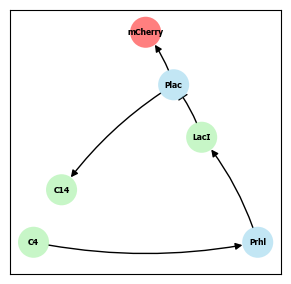

In [20]:
plt.figure(figsize=(3.5,3.5), dpi=100)
gn1.draw(pos=nx.planar_layout)

## Strain 2 (two nodes)

In [11]:
gn2 = lc.GeneticNetwork()
metab2 = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
strain_2 = lc.Strain('Strain 2', gn2, metab2)

In [12]:
# Transcription factors
laci_2 = lc.Regulator(name='LacI', degradation_rate=1)
tetr_2 = lc.Regulator(name='TetR', degradation_rate=1)

# Signalling molecules
c4_2 = lc.Regulator(name='C4', degradation_rate=1, diffusion_rate=1)
c14_2 = lc.Regulator(name='C14', degradation_rate=1, diffusion_rate=1)

gn2.add_regulator([tetr_2, laci_2, c4_2, c14_2])

In [13]:
# option with producers
# rhli = lc.Regulator(name='RhlI', degradation_rate=1)
# gn2.add_regulator(rhli)

In [14]:
cyan = lc.Reporter(name='CFP', degradation_rate=1, color='blue') 
mven = lc.Reporter(name='mVenus', degradation_rate=1, color='yellow') 

gn2.add_reporter([cyan, mven])

In [15]:
# One node
c14_laci = lc.Hill1(name='Pcin', input=c14_2, output=laci_2, alpha=[0.1,10000], K=10, n=2)
laci_not_tetr = lc.Hill1(name='Plac', input=laci_2, output=[tetr_2, mven], alpha=[10000,0.1], K=10, n=2)
# Second node
tetr_not_c4 = lc.Hill1(name='Ptet', input=tetr_2, output=[c4_2, cyan], alpha=[10000,0.1], K=10, n=2)

gn2.add_operator([c4_laci, laci_not_tetr, tetr_not_c4])

In [16]:
# # option with producers
# # One node
# c14_laci = lc.Hill1(name='Pcin', input=c14_2, output=laci_2, alpha=[0.1,10000], K=10, n=2)
# laci_not_tetr = lc.Hill1(name='Plac', input=laci_2, output=[tetr_2, mven], alpha=[10000,0.1], K=10, n=2)
# # Second node
# tetr_not_c4 = lc.Hill1(name='Ptet', input=tetr_2, output=[rhli, cyan], alpha=[10000,0.1], K=10, n=2)
# rhli_c4 = lc.Producer(name='ScbB', input=rhli, output=c4_2, k1a=1, k2=1)

# gn2.add_operator([c4_laci, laci_not_tetr, tetr_not_c4, rhli_c4])

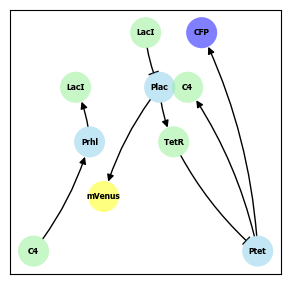

In [19]:
plt.figure(figsize=(3.5,3.5), dpi=100)
gn2.draw(pos=nx.planar_layout)

In [18]:
sample = lc.Sample(strain=[strain_1, strain_2])
# set starting external concentration
sample.set_ext_conc('C4', 50)
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Extended repressilator',
                description='Simulated expression of extended repressilator strain'
                )